# First analysis of geographical data

For performance reasons only may data is used.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import HeatMap

In [69]:
may_data = pd.read_csv("may_data.csv", parse_dates=["start_time","end_time"])
may_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363319 entries, 0 to 363318
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Unnamed: 0          363319 non-null  int64         
 1   start_time          363319 non-null  datetime64[ns]
 2   end_time            363319 non-null  datetime64[ns]
 3   start_station_id    363319 non-null  int64         
 4   end_station_id      363319 non-null  int64         
 5   start_station_name  363319 non-null  object        
 6   end_station_name    363319 non-null  object        
 7   bike_id             363319 non-null  int64         
 8   user_type           363319 non-null  object        
 9   Month               363319 non-null  int64         
 10  duration            363319 non-null  object        
 11  day                 363319 non-null  int64         
dtypes: datetime64[ns](2), int64(6), object(4)
memory usage: 33.3+ MB


In [172]:
coordinates = pd.read_csv("../Divvy_Stations_2016_Q1Q2.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           535 non-null    int64  
 1   name         535 non-null    object 
 2   latitude     535 non-null    float64
 3   longitude    535 non-null    float64
 4   dpcapacity   535 non-null    int64  
 5   online_date  535 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 25.2+ KB


In [241]:
#aggregate; started trip = ended trip = 1 activity
activity = start_count.to_frame().merge(end_count,left_on=start_count.index,right_on=end_count.index,how="outer")
activity = activity.rename(columns={"key_0":"station_name","end_station_name":"finished_trips","start_station_name":"started_trips"})
#set null values to 0
activity = activity.fillna(value=0)
#add activity column
activity["activities"] = activity["finished_trips"]+activity["started_trips"]
activity.head()

#add coordinates to stations
coordinates["ziped_coords"] = list(zip(coordinates["latitude"],coordinates["longitude"]))
activity = activity.merge(coordinates["ziped_coords"].to_frame(),how = "left",left_on=activity["station_name"],right_on=coordinates["name"])
activity = activity.drop(columns=["key_0"])
#drop stations without location data !!! maybe the data is in other datasets
activity = activity.dropna(axis=0)
activity = activity.sort_values(by="activities",ascending=False)
activity.head(3)

,station_name,started_trips,finished_trips,activities,ziped_coords
0,Streeter Dr & Grand Ave,9488.0,10823,20311.0,"(41.892278000000005, -87.612043)"
1,Theater on the Lake,6044.0,6484,12528.0,"(41.926277, -87.630834)"
2,Lake Shore Dr & Monroe St,5986.0,5694,11680.0,"(41.880958, -87.616743)"


In [255]:
#stations; size->logarithmic number of started tours
#red ones have more started trips than finished trips
#blue ones have more finished trips than started ones
log_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

for index, row in activity.iterrows():
    diff_color = "red" if row["started_trips"] > row["finished_trips"] else "blue"
    folium.CircleMarker(radius=np.power(np.log(row["activities"])/2,1.5), location=row["ziped_coords"], popup=row["station_name"], color=diff_color, fill_color=diff_color).add_to(log_map)
log_map

<BarContainer object of 50 artists>

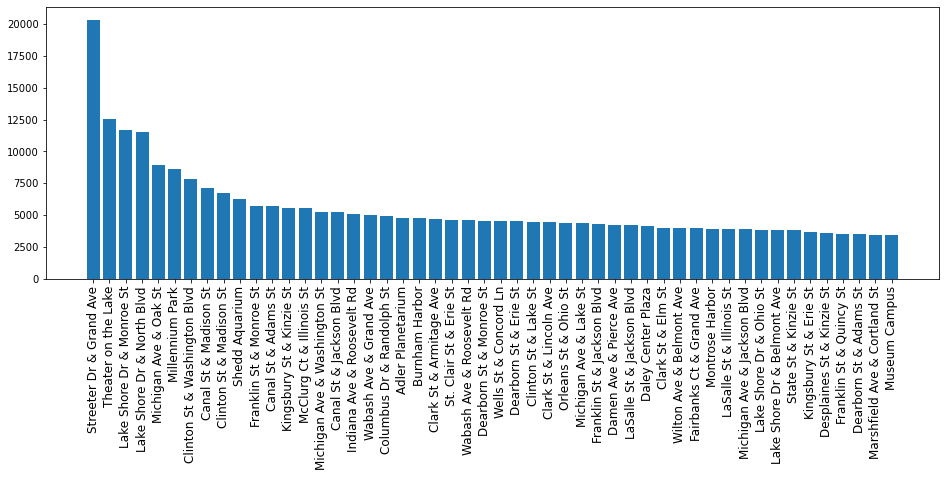

In [247]:
#stations by most activity (started and ended trips)
fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(activity["station_name"].iloc[:50], activity["activities"].iloc[:50])

<BarContainer object of 50 artists>

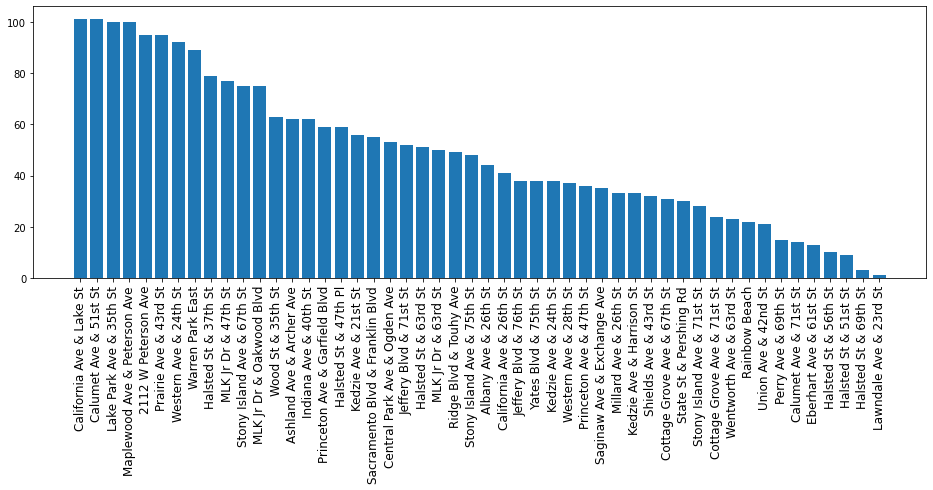

In [246]:
#stations by least activity (started and ended trips)
fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(activity["station_name"].iloc[-50:], activity["activities"].iloc[-50:])

In [249]:
#most an least used stations on a map
#blue -> least used
#red -> most used
log_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)
#add most used
for index, row in activity.iloc[:50].iterrows():
    folium.CircleMarker(radius=5, location=row["ziped_coords"], popup=row["station_name"], color="red", fill_color="red").add_to(log_map)
#add least used
for index, row in activity.iloc[-50:].iterrows():
    folium.CircleMarker(radius=5, location=row["ziped_coords"], popup=row["station_name"], color="blue", fill_color="blue").add_to(log_map)
log_map